In [254]:
# Import dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [194]:
# Read data
red_zone_line_player_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneLinePlayerProximity.csv')
red_zone_qb_proximity = pd.read_csv('https://storage.googleapis.com/big-data-bowl/redZoneQBProximity.csv')
players = pd.read_csv('https://storage.googleapis.com/big-data-bowl/players.csv')

In [70]:
# Define matchup threshold
matchup_distance_threshold = 1
matchup_duration_threshold = 20

In [77]:
# Get unique matchups that fall below threshold for frames exceeding the matchup duration_threshold
red_zone_line_player_matchups = red_zone_line_player_proximity[red_zone_line_player_proximity['distance'] <= matchup_distance_threshold]
unique_matchups = red_zone_line_player_matchups[['gameId', 'playId', 'nflId', 'nflId2', 'frameId']].groupby(['gameId', 'playId', 'nflId', 'nflId2']).min().reset_index()

In [106]:
# Initialize confirmed matchups DataFrame
confirmed_matchups = pd.DataFrame()

In [107]:
# Add matchup that last for more frames than matchup_duration_threshold to confirmed matchups DataFrame
for i, r in unique_matchups.iterrows():
    matchup = True
    for f in range(matchup_duration_threshold):
        matchup_frame = red_zone_line_player_matchups[
            (red_zone_line_player_matchups['gameId'] == r['gameId']) & \
            (red_zone_line_player_matchups['playId'] == r['playId']) & \
            (red_zone_line_player_matchups['nflId'] == r['nflId']) & \
            (red_zone_line_player_matchups['nflId2'] == r['nflId2']) & \
            (red_zone_line_player_matchups['frameId'] == r['frameId'] + f)
        ]
        if len(matchup_frame) == 0:
            matchup = False
            break
    if matchup:
        confirmed_matchups = confirmed_matchups.append(r)

In [109]:
# Clean confirmed matchups
confirmed_matchups = confirmed_matchups.rename(columns={'frameId': 'firstFrameId'})
confirmed_matchups['lastFrameId'] = confirmed_matchups['firstFrameId'].apply(lambda x: x + 20)

In [122]:
# Merge defensive player's initial distance to QB
matchup_qb_distance = confirmed_matchups.merge(
    red_zone_qb_proximity,
    left_on=['gameId', 'playId', 'firstFrameId', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId2'],
    how='inner',
    suffixes=('', '_qb')
)

In [123]:
# Merge defensive player's initial distance to QB
matchup_qb_distance = matchup_qb_distance.merge(
    red_zone_qb_proximity,
    left_on=['gameId', 'playId', 'lastFrameId', 'nflId'],
    right_on=['gameId', 'playId', 'frameId', 'nflId2'],
    how='inner',
    suffixes=('', '_final')
)

In [128]:
# Find pocket progression across matchup frames
matchup_qb_distance['progression'] = matchup_qb_distance.apply(lambda r: r['distance_final'] - r['distance'], axis=1)

In [187]:
# Drop unused columns
matchup_qb_distance = matchup_qb_distance[['gameId', 'playId', 'nflId', 'nflId2', 'progression']]

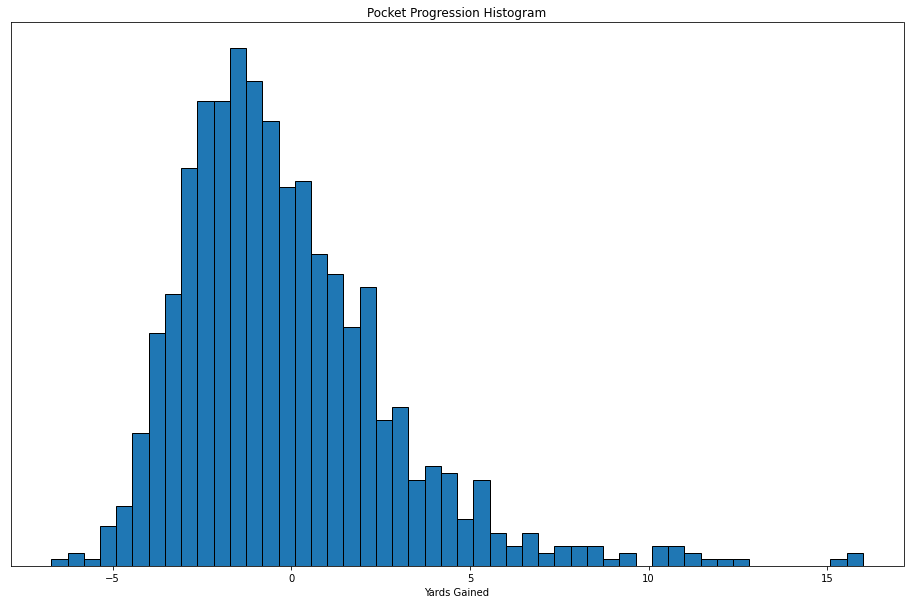

In [151]:
# Plot histogram
plt.figure(figsize=(16, 10))
plt.hist(matchup_qb_distance['progression'], bins=50, edgecolor='black')
plt.yticks([])
plt.xlabel('Yards Gained')
plt.title('Pocket Progression Histogram')
plt.show()

In [260]:
# Merge player data
players_cleaned = players.copy()
players_cleaned.dropna(subset=['birthDate', 'height', 'weight'], inplace=True)
players_cleaned['age'] = players_cleaned['birthDate'].str.extract('(\d{4})')
players_cleaned['age'] = players_cleaned['age'].apply(lambda x: 2021 - int(x))

players_cleaned['height'] = players_cleaned['height'].apply(lambda x: int(x.split('-')[0]) + int(x.split('-')[1])/12)
player_matchup_progression = matchup_qb_distance.merge(players_cleaned)
player_matchup_progression = player_matchup_progression.merge(
    players_cleaned,
    left_on=['nflId2'],
    right_on=['nflId'],
    suffixes=('_defense', '_offense')
)

ml_data = player_matchup_progression[[
    'nflId_defense',
    'nflId_offense',
    'height_offense',
    'weight_offense',
    'age_offense',
    'height_defense',
    'weight_defense',
    'age_defense',
    'progression'
]]

In [261]:
y = ml_data['progression'].apply(lambda x: int(x > 0))
X = ml_data.drop(columns=['progression', 'nflId_defense', 'nflId_offense'])
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [262]:
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.6025641025641025


In [265]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(ml_data[['nflId_defense', 'nflId_offense']]))
encode_df
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(['nflId_defense', 'nflId_offense'])

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [266]:
# Merge one-hot encoded features and drop the originals
ml_data2 = ml_data.merge(encode_df,left_index=True, right_index=True)
ml_data2 = ml_data2.drop(['nflId_defense', 'nflId_offense'],1)

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [301]:
y = ml_data2['progression'].apply(lambda x: int(x > 0))
X = ml_data2.drop(columns=['progression'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [302]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train

,height_offense,weight_offense,age_offense,height_defense,weight_defense,age_defense,nflId_defense_33131.0,nflId_defense_34777.0,nflId_defense_35441.0,nflId_defense_35449.0,...,nflId_offense_52554,nflId_offense_52589,nflId_offense_52590,nflId_offense_52600,nflId_offense_52603,nflId_offense_52666,nflId_offense_52783,nflId_offense_52894,nflId_offense_52938,nflId_offense_53063
596,6.500000,315,23,6.333333,342,24,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
771,6.250000,247,27,6.000000,243,28,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536,6.250000,300,32,6.166667,315,28,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,6.500000,335,33,6.416667,318,23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,6.166667,315,32,6.166667,287,25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,6.416667,320,22,6.333333,242,24,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,6.500000,320,28,6.500000,296,27,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
629,6.250000,309,29,6.250000,311,26,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559,6.333333,307,30,6.333333,329,33,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [303]:
# Define the model - deep neural net
number_input_features = len(X_train.iloc[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=120, input_dim=number_input_features, activation="relu"))
nn.add(tf.keras.layers.Dense(units=120, activation="relu"))
nn.add(tf.keras.layers.Dense(units=120, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 120)               55560     
                                                                 
 dense_42 (Dense)            (None, 120)               14520     
                                                                 
 dense_43 (Dense)            (None, 120)               14520     
                                                                 
 dense_44 (Dense)            (None, 1)                 121       
                                                                 
Total params: 84,721
Trainable params: 84,721
Non-trainable params: 0
_________________________________________________________________


In [304]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [305]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
19/19 [==============================] - 1s 2ms/step - loss: 0.7139 - accuracy: 0.5573
Epoch 2/100
19/19 [==============================] - 0s 1ms/step - loss: 0.5589 - accuracy: 0.6838
Epoch 3/100
19/19 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.8735
Epoch 4/100
19/19 [==============================] - 0s 1ms/step - loss: 0.3033 - accuracy: 0.8957
Epoch 5/100
19/19 [==============================] - 0s 1ms/step - loss: 0.1984 - accuracy: 0.9419
Epoch 6/100
19/19 [==============================] - 0s 1ms/step - loss: 0.1388 - accuracy: 0.9453
Epoch 7/100
19/19 [==============================] - 0s 1ms/step - loss: 0.1198 - accuracy: 0.9419
Epoch 8/100
19/19 [==============================] - 0s 1ms/step - loss: 0.1108 - accuracy: 0.9402
Epoch 9/100
19/19 [==============================] - 0s 1ms/step - loss: 0.1057 - accuracy: 0.9402
Epoch 10/100
19/19 [==============================] - 0s 1ms/step - loss: 0.1064 - accuracy: 0.9419
Epoch 11/

19/19 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9521
Epoch 84/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0703 - accuracy: 0.9436
Epoch 85/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.9487
Epoch 86/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0694 - accuracy: 0.9470
Epoch 87/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9419
Epoch 88/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 0.9504
Epoch 89/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0695 - accuracy: 0.9436
Epoch 90/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9453
Epoch 91/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0691 - accuracy: 0.9453
Epoch 92/100
19/19 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 0.9385
Epoch 93/100


In [306]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

7/7 - 0s - loss: 3.2328 - accuracy: 0.5692 - 312ms/epoch - 45ms/step
Loss: 3.2328364849090576, Accuracy: 0.5692307949066162
